#### Imports

In [64]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

print("successfull imports!!")

successfull imports!!


In [65]:
print(tf.__version__)

2.1.0


#### Hyperparameters

In [66]:
MAX_SEQUENCE_LENGTH = 200
MAX_VOCAB_SIZE = 30000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

#### load in pre-trained word vectors

In [67]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../assets/word_vectors/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))



Loading word vectors...
Found 400000 word vectors.


In [68]:
glove_100_file = open(os.path.join('../assets/jigsaw_toxic_comment_classification/train.csv')) 
for i, line in enumerate(glove_100_file):
    print(line)
    if i>2:
        break

"id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"

"0000997932d777bf","Explanation

Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0

"000103f0d9cfb60f","D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0



In [69]:
train = pd.read_csv("../assets/jigsaw_toxic_comment_classification/train.csv")
ss = train.columns.values[2:]

In [70]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("../assets/jigsaw_toxic_comment_classification/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values
print("shape of targets:", np.shape(targets))
print("Found %s number of comments in training set" % len(sentences))

Loading in comments...
shape of targets: (159571, 6)
Found 159571 number of comments in training set


In [71]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [72]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

max sequence length: 1400
min sequence length: 0
median sequence length: 35


In [73]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [74]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 200)


In [76]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
missing_words = 0
missing_words_index = []
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector
    else:
      missing_words+=1
      missing_words_index.append(i)
print("embedding matrix shape: ", np.shape(embedding_matrix))
print("missing words count: ", missing_words)
print(missing_words_index[:20])

Filling pre-trained embeddings...
embedding matrix shape:  (30000, 100)
missing words count:  3005
[59, 73, 78, 144, 173, 196, 205, 228, 234, 236, 248, 291, 389, 415, 476, 490, 516, 578, 600, 605]


In [77]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [78]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

Building model...


In [79]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 99s 775us/step - loss: 0.0850 - accuracy: 0.9726 - val_loss: 0.0786 - val_accuracy: 0.9740
Epoch 2/10
127656/127656 [==============================] - 103s 805us/step - loss: 0.0696 - accuracy: 0.9767 - val_loss: 0.0727 - val_accuracy: 0.9763
Epoch 3/10
127656/127656 [==============================] - 104s 812us/step - loss: 0.0652 - accuracy: 0.9778 - val_loss: 0.0797 - val_accuracy: 0.9754
Epoch 4/10
127656/127656 [==============================] - 104s 815us/step - loss: 0.0623 - accuracy: 0.9785 - val_loss: 0.0866 - val_accuracy: 0.9720
Epoch 5/10
127656/127656 [==============================] - 104s 814us/step - loss: 0.0600 - accuracy: 0.9792 - val_loss: 0.0777 - val_accuracy: 0.9768
Epoch 6/10
127656/127656 [==============================] - 104s 816us/step - loss: 0.0581 - accuracy: 0.9797 - val_loss: 0.0783 - val_accuracy: 0.9766
Epoch 7/10
127656/12

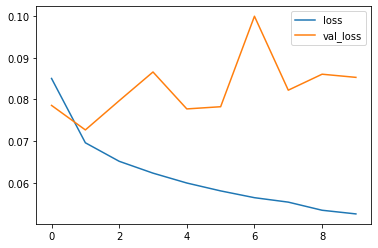

In [80]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()



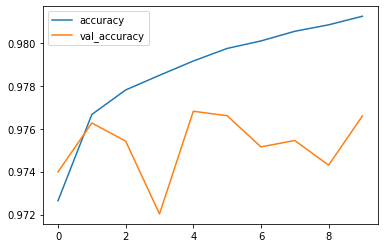

0.9729415397549716


In [81]:
# accuracies
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

## Load test.csv and run the model on it